Stuart Rossiter, C00284845

# Licensing
Random Forest on the January 2017 dataset of Lichess Games Copyright (C) 2025 Stuart Rossiter

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/.

# Random Forest - Stopping the overfitting of Decision Trees

Decision Trees are prone to overfitting, as was the case with the Decision Tree attempting to model chess games by termination. With the use of Random Forests, the average of many models is taken to quell some of this overfitting, which is what we'll be doing now. As always, first we must clean the data, and split it into training and testing data. There are over 10 million games in the acquired dataset. Of these games, a sample of ~300,000 games has been taken. In this case, only the white_elo, black_elo, and winner will be needed.

In [15]:
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

data = pandas.read_csv("Lichess_Games_Sample.csv")

black_elo = data["black_elo"].values
white_elo = data["white_elo"].values
termination_strings = data["termination"].values
termination_types = list(set(x for x in termination_strings))
termination = [termination_types.index(x) for x in termination_strings]

train_black_elo, test_black_elo, train_white_elo, test_white_elo, train_termination, test_termination = train_test_split(black_elo, white_elo, termination, train_size=0.7)

Now that our data has been cleaned and formatted, let's plot our data first, using a single decision tree. This is for reference use later. This is exactly as we've done before.

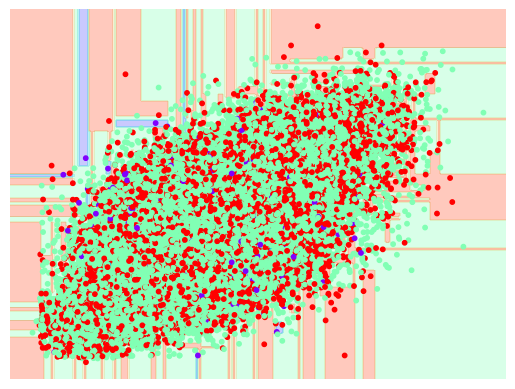

In [16]:
from sklearn.tree import DecisionTreeClassifier

def visualize_classifier(model, X, y, alpha=1, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cmap, clim=(min(y), max(y)), zorder=3, alpha=alpha)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
visualize_classifier(DecisionTreeClassifier(), np.column_stack((train_black_elo, train_white_elo)), train_termination)

Now, in an effort to combat this overfitting, let's use a Random Forest instead.

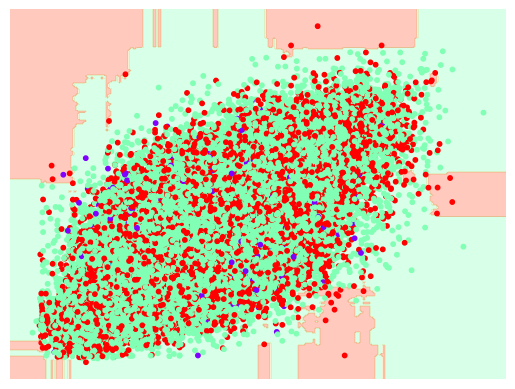

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
visualize_classifier(model, np.column_stack((train_black_elo, train_white_elo)), train_termination)

This certainly looks a little better. Let's remove the points for a better look.

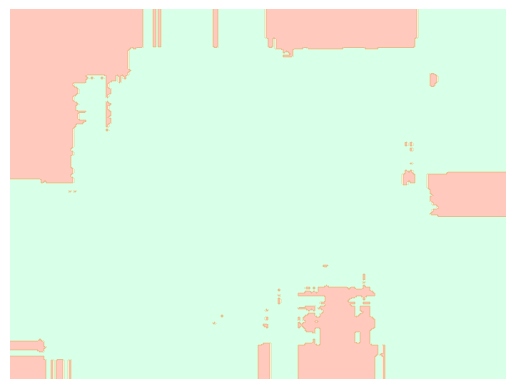

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
visualize_classifier(model, np.column_stack((train_black_elo, train_white_elo)), train_termination, alpha=0)

While certainly not amazing, it is much better than the single Decision Tree. Let's check the accuracy of the model using the test data. We will visualize the accuracy with a confusion matrix.

Text(118.78333333333332, 0.5, 'predicted label')

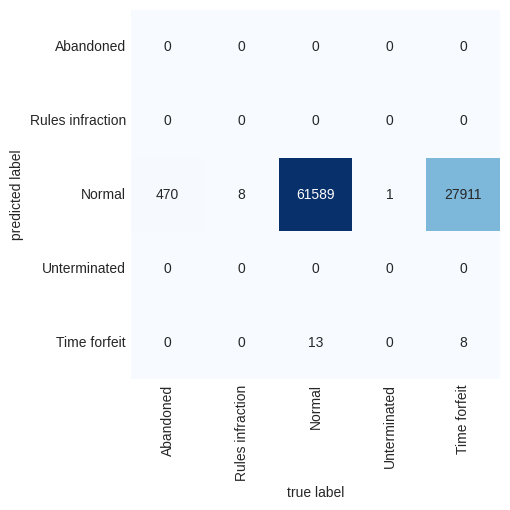

In [25]:
model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
model.fit(np.column_stack((train_black_elo, train_white_elo)), train_termination)
predictedTermination = model.predict(np.column_stack((test_black_elo, test_white_elo)))
import sklearn.metrics as mtc
import seaborn as sb

matrix = mtc.confusion_matrix(test_termination, predictedTermination, labels=[x for x in range(len(termination_types))])

sb.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Abandoned', 'Rules infraction', 'Normal', 'Unterminated', 'Time forfeit'], yticklabels=['Abandoned', 'Rules infraction', 'Normal', 'Unterminated', 'Time forfeit'],
            cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

The model seems to be rather confused. It only seems to predict Normal. This is likely due to a lack of features, and could be improved upon.

# Conclusion
Given the features supplied, it resulted in an inaccurate model. It predicted the most games ending in normal means, only predicting 21 of 90,000 games as anything other than normal. Granted, it got 8 of those 21 correct, but that does not matter. Almost a third of predicted values ended up being incorrectly predicted.